### Motifs ###

Given a network $G=(V,E)$, a **motif** is a small, connected subgraph $G' = (V'\subset V, E' \subset E)$ with a particular **pattern** of edges.

Usually, we want to **count** how often a motif $G'$ occurs within a larger network $G$.
The computational cost of counting motifs **scales up quickly** with the size of $V'$, so most **motif-based measures** focus on motifs of size 2, 3, or 4.

### Reciprocity (in directed networks) ###

The smallest non-trivial motif in a **directed network** is a **reciprocated edge**.

<img src="images/reciprocity.png" alt="Reciprocity of an edge in directed networks" title="Reciprocity of an edge in directed networks" style="width: 400px;"/>

The **reciprocity** of a network $r$ is given by the fraction of links that are reciprocated:
$$r = \frac{1}{m} \sum_{ij} A_{ij}A_{ji}$$
assuming that edges have unit weight.

The **local reciprocity** of node $i$ is:
$$r_i = \frac{1}{k^{\mathrm{out}}_i} \sum_j A_{ij}A_{ji}$$

### Clustering coefficient (in undirected networks) ###

In an **undirected** network, we start from motifs of size 3.
The **clustering coefficient** $C$ is a network-level measure that captures the **relative frequency of triangles**
in a network:
$$C = \frac{\text{(number of triangles)} \cdot 3}{\text{(number of connected triplets)}} = \frac{\sum_{ijk} A_{ij}A_{jk}A_{ki}}{\sum{\substack{ijk\\k\neq i}} A_{ij}A_{jk}}$$
$C$ is the ratio of "closed triangles" (cycles of length 3) over "open triangles" (paths of length 2).

<img src="images/clustering.png" alt="Open and closed triangle" title="Open and closed triangle" style="width: 400px;"/>

Calculating $C$ directly from the definition would take $O(n^3)$ time (3 nested sums over $n$ elements).
How long would it take to calculate $C$ using an adjacency list representation?

### Clustering coefficient: example ###

What is the value of $C$ for the following graph?

<img src="images/sample_graph.png" alt="A sample graph" title="A sample graph" style="width: 400px;"/>

- the clique on the right has 6 vertices, thus $\binom{6}{3}=20$ triangles and $20\cdot 3 = 60$ connected triplets.
- the cycle contains 6 connected triplets and no triangles
- finally, there are 2 connected triples starting from the cycle and 5 connected triples starting from the clique that use the edge joining the cycle to the clique

Result: $C = \frac{60}{73} = 0.82$

### Local clustering coefficient ###

The **local clustering coefficient** $C_i$ is the node-level version of $C$:
$$C_i = \frac{\text{number of pairs of neighbors of $i$ that are connected}}{\text{number of pairs of neighbors of $i$}} = \frac{\sum_{j<k} A_{ij}A_{jk}A_{ki}}{\binom{k_i}{2}}$$

In the above example, the red vertex has $C_i = 0$ because it participates in no triangles.
Its neighbors in the clique has $C_i = \frac{10}{15} = 0.67$.

### Feed-forward and feedback loops (in directed networks) ###

$C$ measures the **transitivity** of the "connected by an edge" relation.
To extend it to directed networks, we need to consider that this relation is *not* symmetric.
Usually, two motifs of size 3 are especially studied: the **feed-forward loop** and the **feedback loop**:
- a FFL has a two-step path $(i, j)$, $(j, k)$ that is shortcut by an $(i, k)$ that "feeds forward" the signal passing along the longer path; the "skipped" node (red in the figure) is the "feed forward" node
- in a FBL, the third edge $(k, i)$ "feeds back" the signal that passed along the longer path

<img src="images/FFL_FBL.png" alt="Feed-forward and feedback loops" title="Feed-forward and feedback loops" style="width: 400px;"/>

In [1]:
import igraph
import pandas as pd

# we re-load the ZK and EN graphs (see Lecture3)
print('ZK:')
ZK = igraph.Graph.Famous('Zachary')
print(ZK.summary())
#
df = pd.read_csv('EN/edges.csv', header=0, names=['source','target','weight','color'])
EN = igraph.Graph.TupleList(df[['source','target','weight']].itertuples(index=False), edge_attrs="weight")
print('EN:')
print(EN.summary())

ZK:
IGRAPH U--- 34 78 -- 
EN:
IGRAPH UNW- 774 1779 -- 
+ attr: name (v), weight (e)


In [2]:
# we also load a Facebook wall-posts graph where edge (i,j) means that i posted on j's wall
# beware of the size of this graph!
df = pd.read_csv('FW/edges.csv', header=0, names=['source','target','weight','time'])
FW = igraph.Graph.TupleList(df.itertuples(index=False), edge_attrs=['weight','time'], directed=True)
print('FW:')
print(FW.summary())

# FW is a multigraph with self-loops and timestamps
# we simplify it, removing self-loops, keeping edge-multiplicity and all timestamps
FW.simplify(combine_edges={'weight':'sum', 'time':lambda x:x})
print('FW simplified:')
print(FW.summary())
e = FW.es[0]
print('the edge of index 0 is', e.tuple, 'and has multiplicity', e['weight'])
print('the timestamps of this edge are:', e['time'])

FW:
IGRAPH DNW- 46952 876993 -- 
+ attr: name (v), time (e), weight (e)
FW simplified:
IGRAPH DNW- 46952 264004 -- 
+ attr: name (v), time (e), weight (e)
the edge of index 0 is (1, 2) and has multiplicity 13.0
the timestamps of this edge are: [1097725406, 1098489762, 1098673897, 1099602800, 1100828851, 1109204517, 1109812281, 1137633708, 1171349373, 1183794101, 1223135323, 1223268478, 1223333012]


In [5]:
print('the global clustering of ZK is:')
print(ZK.transitivity_undirected())
print()

print('the global clustering of EN is:')
print(EN.transitivity_undirected())

# qui guardando il clustering globale non mi sembra ci sia una grandissima differenza! vado a vedere quindi localmente

the global clustering of ZK is:
0.2556818181818182

the global clustering of EN is:
0.4296909655478338


the local clustering of ZK and EN has the following distribution:


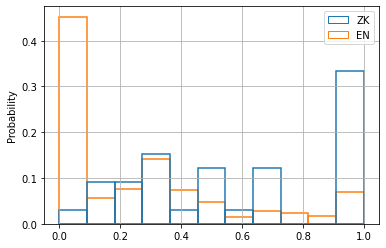

In [4]:
print('the local clustering of ZK and EN has the following distribution:')
ZK_cl = ZK.transitivity_local_undirected()
EN_cl = EN.transitivity_local_undirected()

import seaborn as sns
import matplotlib.pyplot as plt
# this is a normalized histogram
ax = sns.histplot({'ZK':ZK_cl,'EN':EN_cl}, fill=False, common_norm=False, stat='probability') 
plt.grid()

# alternatively, try this:
# ax = sns.ecdfplot({'ZK':ZK_cl,'EN':EN_cl}, complementary=True)
# ecdf is the empirical CDF, with complementary=True seaborn plots the empirical CCDF

#qui vedo che 
# ZK ha molti nodi con clustering coefficient locale alto
# EN ha molti nodi con un clustering coeff locale basso
# questo mi fa capire che questi due sistemi hanno una proprietà strutturale come la frequenza dei triangoli che 
# segue distribuzioni molto diverse. 

In [6]:
import numpy as np
from scipy.sparse import csr_matrix

# questa funzione dato un grafo calcola la frequenza di FFL e FBL
# se sparse=True esegue il calcolo con la matrice sparsa
def FFL_FBL(graph, sparse=True):
    '''
        Compute the frequency of Feed-Forward Loops and Feed-Back Loops
        FFL: this is the probability that, given A->B and A->C, then B->C and/or C->B
        FBL: this is the probability that, given C->A and A->B, then B->C
        vertices with zero denominator (no triplets) are assigned 0 transitivity

        :graph: an igraph Graph object
        :sparse: whether the sparse matrix representation must be used (slower but memory-friendly)
    '''

    if sparse:
        data = np.ones(graph.ecount())
        indptr = [0]
        indices = []
        for adjl in graph.get_adjlist():
            indices.extend(adjl)
            indptr.append(len(indices))
        A = csr_matrix((data,indices,indptr), shape=(graph.vcount(),graph.vcount()))
    else:
        A = np.asarray(graph.get_adjacency().data)

    A_sqr = A.dot(A)
    cycles_d = np.sum(A_sqr)
    cycles_n = np.sum((A_sqr.dot(A)).diagonal())
    if cycles_d != 0:
        tglob_cycles = cycles_n/cycles_d
    else:
        tglob_cycles = 0.0

    A_max = A.maximum(A.transpose())
    At_A  = A.transpose().dot(A)
    any_d = np.sum(At_A)
    any_n = np.sum((At_A.dot(A_max)).diagonal())
    if any_d != 0:
        tglob_any = any_n/any_d
    else:
        tglob_any = 0.0

    return tglob_any, tglob_cycles

In [8]:
FFL, FBL = FFL_FBL(FW, sparse=True)
print('FFL frequency in FW:', FFL)
print('FBL frequency in FW:', FBL)

FFL frequency in FW: 0.09724444414526946
FBL frequency in FW: 0.061849884721592883


### Shortest paths and network position ###

Reminder: a **path** is a sequence of vertices $i_0,\ldots,i_k$ such that $(i_h,i_{h+1})\in E$ for all $h=0,\ldots,k-1$; $k$ is the **length** of the path.

A **shortest path** (or *geodesic* path) is the shortest of all possible paths between two vertices and the **distance** $l_{ij}$ between node $i$ and $j$ is the length of the shortest path from $i$ to $j$.  

<img src="images/geodesic.png" alt="The shortest path from x to z" title="The shortest path from x to z" style="width: 350px;"/>

### Shortest paths and network position ###

(Nearly) all **positional** measures are based on the computation of the distances $l_{ij}$ between all pairs of nodes $i, j$.
Usually, we accomplish this by applying an off-the-shelf algorithm for the **All Pairs Shortest Paths** (APSP) problem, generally:
- a **Breadth First Search** (BFS) to solve the *single-source* shortest path problem on **unweighted** networks (run once per node)
- **Dijkstra**'s algorithm to solve the *single-source* *lightest* path (mimumum sum of weights) problem on networks with **positive weights** (run once per node)
- the **Floyd-Warshall** algorithm to get all **weighted** distances (weight of the *lightest* path) in a generic weighted network

The result will be a **pairwise distance matrix** $l$ with entries $l_{ij}$.
If there is no path from $i$ to $j$, then $l_{ij} = \infty$ and we say that $j$ is not **reachable** from $i$.

### Search trees on graphs ###

A **tree** is a **connected acyclic undirected** graph

<img src="images/tree.png" alt="A tree" title="A tree" style="width: 300px;"/>


Many operations on graphs rely on finding a suitable **search tree**:
- take as input a graph $G = (V, E)$ and a source vertex $s \in V$
- explore the graph one edge at a time
- while exploring, build the path $s \to t \to \cdots \to z$ to all vertices $z \in V$
- return the set of all such paths, called the search tree $T$ *rooted* in $s$

### Search trees on graphs ###

The basic structure of all search tree algorithms looks like this:

<img src="images/search_tree_algorithm.png" alt="The generic algorithm of a search tree" title="The generic algorithm of a search tree" style="width: 400px;"/>

- the underlying data structure is a **queue**, i.e., a sequence of elements that can be added/removed only from the ends of the sequence
- when Search-Tree terminates, all nodes reachable from $s$ have been marked
- the array $p$ contains the search tree $T$
- the value $d[i]$ is the distance in the search tree from $s$ to $i$

### Breadth-First Search and Depth-First Search ###

- in a Breadth-First Search (**BFS**), the queue is a FIFO (first-in-first-out): vertices are added to the end and removed from the front
- in a Depth-First-Search (**DFS**), the queue is a FILO (first-in-last-out): vertices are added and removed from the same side

BFS | DFS
:-: | :-:
<img src="images/bfs.gif" alt="BFS algorithm" title="BFS algorithm" style="width: 300px;"/> | <img src="images/dfs.gif" alt="BFS algorithm" title="BFS algorithm" style="width: 280px;"/>

BFS and DFS produce **very different** output trees:
- BFS visits **all** neighbors of a vertex $t$ before proceedings; in BFS, all vertices at a distance $l$ from the source $s$ are visited before any vertices at a distance $l+1$
- DFS visits **one** neighbor $u$ of $t$, then **one** neighbor $v$ of $u$, etc.; DFS always pushes "deeper" into the graph, backtracking only when no new vertices can be reached

Question: why can we use a BFS to compute all distances?

### Dijkstra's algorithm ###

In a graph with **positive weights**, **Dijkstra**'s algorithm computes all **weighted distances** from a source $s\in V$ to all other vertices by induction:
- all vertices are initially given a *tentative* distance equal to $\infty$
- once the distance to a vertex $t$ has been computed, the tentative distance of all neighbors $u$ of $t$ through $t$ is computed as the distance from $s$ to $t$ plus the weight of the edge $(t,u)$
- if this distance is less than the previous tentative distance of $u$, the tentative distance of $u$ is updated with the new value through $t$

<img src="images/dijkstra.gif" alt="Dijkstra's algorithm" title="Dijkstra's algorithm" style="width: 300px;"/>

In [9]:
print('shortest paths from vertex 0 of ZK to the first 10 vertices:')
print(ZK.get_shortest_paths(0, to=range(10)))

print('shortest paths from vertex 0 of EN to the first 10 vertices:')
print(EN.get_shortest_paths(0, to=range(10)))

print('shortest paths FROM vertex 1 of FW to some vertices:')
print(FW.get_shortest_paths(1, to=[21,37,59,109,1003,2560,40876]))
print('shortest paths TO vertex 1 of FW from the same vertices:')
print(FW.get_shortest_paths(1, to=[21,37,59,109,1003,2560,40876], mode='in'))

shortest paths from vertex 0 of ZK to the first 10 vertices:
[[0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 2, 9]]
shortest paths from vertex 0 of EN to the first 10 vertices:
[[0], [0, 1], [0, 1, 282, 331, 598, 3, 2], [0, 1, 282, 331, 598, 3], [0, 1, 282, 33, 5, 4], [0, 1, 282, 33, 5], [0, 1, 282, 31, 7, 6], [0, 1, 282, 31, 7], [0, 1, 282, 31, 7, 6, 8], [0, 1, 282, 44, 98, 102, 12, 9]]
shortest paths FROM vertex 1 of FW to some vertices:
[[1, 21], [1, 3, 2094, 30, 23, 37], [1, 3, 2094, 4945, 59], [1, 4, 103, 102, 109], [1, 3, 6944, 4187, 1692, 1003], [1, 5, 95, 2558, 2560], []]
shortest paths TO vertex 1 of FW from the same vertices:
[[1, 6, 21], [1, 5, 8906, 27, 23, 37], [1, 5, 1588, 1585, 60, 59], [1, 6, 1733, 36, 114, 109], [1, 8, 6944, 3, 79, 1003], [1, 6, 2731, 8549, 2560], [1, 6, 2380, 12025, 40876]]


C:\Users\Federico\AppData\Local\Temp\ipykernel_13236\2789607523.py:8: RuntimeWarning: Couldn't reach some vertices at src/paths/unweighted.c:368
  print(FW.get_shortest_paths(1, to=[21,37,59,109,1003,2560,40876]))


In [10]:
print('the distance from vertex 1 to vertex 5 in ZK:')
print(ZK.shortest_paths(source=1, target=5))

print('the distance from vertex 1 to vertex 5 in EN:')
print(EN.shortest_paths(source=1, target=5))

print('the weighted distance from vertex 1 to vertex 59 in FW:')
print(FW.shortest_paths(source=1, target=59, weights='weight'))

print('beware of how shortest_paths() interprets the weights!')

the distance from vertex 1 to vertex 5 in ZK:
[[2]]
the distance from vertex 1 to vertex 5 in EN:
[[3]]
the weighted distance from vertex 1 to vertex 59 in FW:
[[6.0]]
beware of how shortest_paths() interprets the weights!


In [12]:
print('the distance matrix for ZK:')
dmatrix = ZK.shortest_paths()
for l in dmatrix:
    print(l)

the distance matrix for ZK:
[0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 3, 2, 1, 3, 1, 3, 1, 3, 3, 2, 2, 3, 2, 2, 3, 2, 1, 2, 2]
[1, 0, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 2, 2, 3, 1, 2, 2, 2]
[1, 1, 0, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 1, 1, 2, 2, 2, 1, 2]
[1, 1, 1, 0, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2]
[1, 2, 2, 2, 0, 2, 1, 2, 2, 3, 1, 2, 2, 2, 4, 4, 2, 2, 4, 2, 4, 2, 4, 4, 3, 3, 4, 3, 3, 4, 3, 2, 3, 3]
[1, 2, 2, 2, 2, 0, 1, 2, 2, 3, 1, 2, 2, 2, 4, 4, 1, 2, 4, 2, 4, 2, 4, 4, 3, 3, 4, 3, 3, 4, 3, 2, 3, 3]
[1, 2, 2, 2, 1, 1, 0, 2, 2, 3, 2, 2, 2, 2, 4, 4, 1, 2, 4, 2, 4, 2, 4, 4, 3, 3, 4, 3, 3, 4, 3, 2, 3, 3]
[1, 1, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 4, 2, 2, 3, 2, 2, 2, 3]
[1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 1, 2, 1, 1]
[2, 2, 1, 2, 3, 3, 3, 2, 2, 0, 3, 3, 3, 2, 2,

## Diameter, eccentricity, average distance ## 

Based on distances, we can introduce a set of positional measures:
- the network's **diameter** is the maximum distance of any two nodes in the graph: $\text{diameter}=\max_{ij} l_{ij}$ 
- the **eccentricity** of node $i$ is the equivalent *local* measure, i.e., the maximum distance of any other node from $i$: $\epsilon_i = \max_j l_{ij}$
- the **average distance**, or **mean shortest path path length**, is a global measure that quantifies how close are the vertices of $G$ on average: $\langle l \rangle = \frac{1}{Z} \sum_{i\neq j} l_{ij}$

Only the *existing* paths are generally considered so that all these measures are $<\infty$. In the expression for $\langle l \rangle$, $Z$ counts the number of the distances involved in the sum.

Remark: if you want to compute several distance-bases metrics on a large graph, compute the distance matrix once and then compute all metrics from the matrix!


In [13]:
print('the diameter of ZK is:', ZK.diameter())
print('the diameter of EN is:', EN.diameter())
# computing the diameter of FW may take some time...
# print('the diameter of FW is:', FW.diameter())

print('the eccentricity of node 1 in ZK is:', ZK.eccentricity(1))
print('the eccentricity of node 1 in EN is:', EN.eccentricity(1))

print('the average distance in ZK is:', ZK.average_path_length())
print('the average distance in EN is:', EN.average_path_length())

print('what do you think of these values with respect to the graph size?')

the diameter of ZK is: 5
the diameter of EN is: 27
the eccentricity of node 1 in ZK is: 3.0
the eccentricity of node 1 in EN is: 16.0
the average distance in ZK is: 2.408199643493761
the average distance in EN is: 8.3826896784567
what do you think of these values with respect to the graph size?


the distances in ZK and EN have the following distribution:


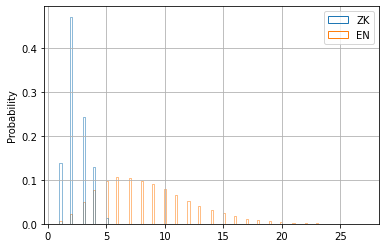

In [14]:
print('the distances in ZK and EN have the following distribution:')
ZK_pl = []
for i in range(ZK.vcount()):
    ZK_pl.extend(ZK.shortest_paths(i,range(i+1,ZK.vcount()))[0])
EN_pl = []
for i in range(EN.vcount()):
    EN_pl.extend(EN.shortest_paths(i,range(i+1,EN.vcount()))[0])

import seaborn as sns
import matplotlib.pyplot as plt
# this is a normalized histogram
ax = sns.histplot({'ZK':ZK_pl,'EN':EN_pl}, fill=False, common_norm=False, stat='probability') 
plt.grid()

### Small worlds and network diameter ###

In **mathematical models** of networks, the diameter can often be shown to vary in a **clean functional** way with the size of the network.

If the diameter grows very *slowly* as a function of network size, e.g., $O(\log n)$, a network is said to exhibit the **small world** property.

The idea comes from a seminal study in social networks by the American sociologist *Stanley Milgram*:
- Milgram mailed letters to "randomly selected" individuals in Omaha, Nebraska and Wichita, Kansas
- the recipient were asked to pass the letter (and instructions) to a friend of theirs who either knew or might be likely to know a particular doctor in Boston
- before forwarding the letter, they should also write their name on a roster to record the chain of message passing

Of the 64 letters that eventually reached the doctor (a small fraction of those sent out) the average length was only 5.5, confirming the "six degrees of separation" theory.

### Small worlds and network diameter ###

Duncan Watts and Steve Strogatz, in a 1998 Science paper, studied this phenomenon using a toy model, now called the **small world model**:
- vertices are arranged on a 1-dimensional circular lattice (a "ring" network)
- each vertex is connected with its $k$ nearest neighbors on the ring
- each edge is then **rewired**, with probability $p$, to connect a uniformly random pair of vertices:
    - at $p = 0$, the network is fully **ordered**, the density of local connections is largest and the diameter is $O(n)$
    - at $p = 1$, the network is fully **disordered**, local connections are absent and the diameter is $O(\log n)$

<img src="images/WS.png" alt="Watts and Strogatz' small world model" title="Watts and Strogatz' small world model" style="width: 500px;"/>

### Small worlds and network diameter ###

What happens when $p$ varies between 0 and 1?

For small $p$, i.e., when only a small number of edges have been randomly rewired:
- the diameter of the network collapses from $O(n)$ to $O(\log n)$
- the local structure is still largely preserved

A highly-ordered "big world" can be transformed into a mostly ordered "small world" by **rewiring** only a **small number** of connections.
In this case, the geodesic paths traverse a **vanishing** fraction of the network that work as bridges to quickly connect the other vertices.

This behavior emerges in many social networks, which have **small diameter** (as evidenced by Milgram's study) but also **many triangles** (i.e., strong local structure).

The small-world result also highlights that some measures of network structure can be **extremely sensitive** to uncertainty in the network structure.
By just missing a few connections we may believe that the diameter is **much larger** than it actually is.

### A few real networks ###

$z$ is the average degree, $l$ the average distance

<img src="images/table_real_graphs.png" alt="Properties of some real graphs" title="Properties of some real graphs" style="width: 500px;"/>

### A few real networks ###

Boxplots showing the within-class distributions of network size ($\log n$), mean degree $z$, and mean distance $l$ (normalized by network size)

<img src="images/per_class_stats.png" alt="Aggregated statistics of a few classes of real graphs" title="Aggregated statistics of a few classes of real graphs" style="width: 800px;"/>

In [15]:
#LETTURA DEI GRAFICI
#linee rosse rappresentano la media
#box blu indica dove sta il 75% dei casi (tra un dev standard e l'altra che se la distro è circa gaussiana è circa il 65-70 % dei casi ) 

#confrontare la linea rossa tra le categorie mi permette di confrontare la media del valore per le varie categorie
#confrontare il box blu e la linea tratteggiata mi permette di confrontare la varianza e il range  delle diverse categorie

### A few real networks ###

Scatter plots for mean degree $z$ and mean distance $l$ versus number of vertices $n$

<img src="images/degree_distance.png" alt="Mean degree and mean distance vs network size" title="Mean degree and mean distance vs network size" style="width: 700px;"/>